In [2]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sn 

# Check data shape

In [14]:
vtv_news = pl.read_ipc("data/vtv_articles_2.feather")

vtv_news = pl.concat([
    vtv_news,
    pl.read_ipc("data/vtv_articles.feather")
])

could not mmap compressed IPC file, defaulting to normal read

In [16]:
vtv_news.unique(subset="link").write_ipc("data/vtv_articles.feather")
# vtv_news.unique(subset="link").shape

## check
|datetime|number of articles|  
|-|-|
|202303121440|61178| 
|202303121503|61307| 
|202303121905|61307| 

# Basic Transform

In [3]:
vtv_news = pl.read_ipc("data/vtv_articles.feather")
# vtv_news = 0

In [7]:
processed_vtv_news = (vtv_news
    .select([
        pl.col("link").apply(lambda x: x.split("/")[-2]).alias("category_substring"), # get the catgory name, embeded in the article url
        pl.col("link").apply(lambda x: x[x.rfind("/")+1:]).alias("link_suffix"), # get only the substring, identical to the article
        pl.col("description").apply(lambda x: x[8:].strip() if x.lower().startswith("vtv.vn") else x), # exclude the VTV.vn prefix
        "title",
        pl.col("datetime").str.strptime(pl.Datetime, fmt="%d/%m/%Y %H:%M")]) # change string to datetime object
)
# processed_vtv_news.write_ipc("data/processed_article_basic_info.arrow")

In [8]:
notable_categories = (processed_vtv_news
        .groupby("category_substring") # try to count how many articles in each cate 
        .agg(pl.count())
        .filter(pl.col("count") > 100) # get only the cates that have over 100 articles 
        [:,0]) # turn ino a numpy array, necessary ? 

In [9]:
cate_count_by_month = (processed_vtv_news
    .filter(pl.col("category_substring").is_in(notable_categories))
    .with_column(pl.col("datetime").dt.strftime(fmt="%Y%m"))
    .groupby(["category_substring","datetime"])
    .agg(pl.count("link_suffix"))
    .sort(by="datetime")
    .to_pandas())

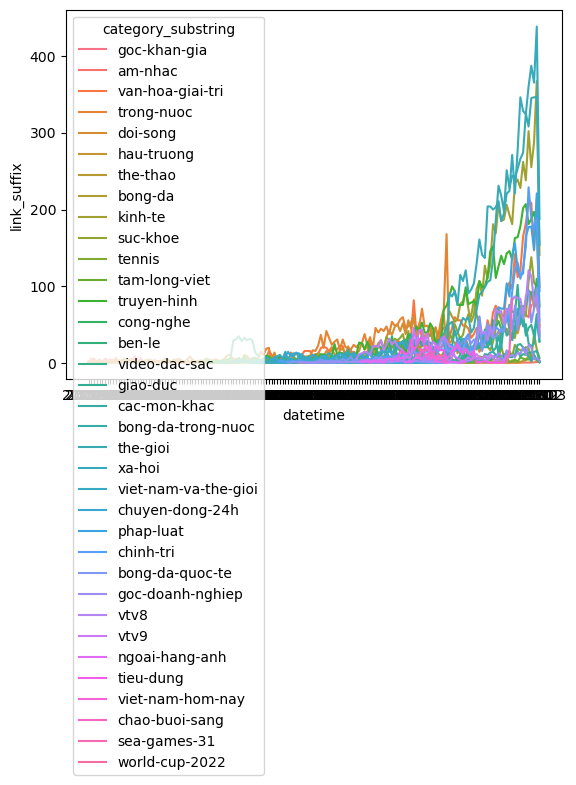

<Figure size 2000x3000 with 0 Axes>

In [12]:
ax = sn.lineplot(cate_count_by_month, x="datetime", y="link_suffix", hue="category_substring")
plt.figure(figsize=(20,30))
plt.show()